In [247]:
using Distributions
using Rocket
using ReactiveMP
using BenchmarkTools
using Plots

import ProgressMeter
using Random

import Base: show
import PDMats: PDMat

In [335]:
function hgf(n, iters, data, z_covariance, y_covariance, kfunction)
    model = Model(DefaultMessageGate())
    
    xt_min_mean = add!(model, datavar(:xt_min_mean, Vector{Float64}))
    xt_min_cov  = add!(model, datavar(:xt_min_cov, PDMat{Float64, Matrix{Float64}}))
    xt_min      = add!(model, randomvar(:xt_min))
    
    xt_min_prior = add!(model, make_node(MvNormalMeanCovariance{Float64}, xt_min_mean, xt_min_cov, xt_min))
    
    zt_min_mean = add!(model, datavar(:zt_min_mean, Vector{Float64}))
    zt_min_cov  = add!(model, datavar(:zt_min_cov, PDMat{Float64, Matrix{Float64}}))
    zt_min      = add!(model, randomvar(:zt_min))
    
    zt_min_prior = add!(model, make_node(MvNormalMeanCovariance{Float64}, zt_min_mean, zt_min_cov, zt_min))
    
    zcov   = add!(model, constvar(:zcov, z_covariance))
    zt     = add!(model, randomvar(:zt))
    
    z_transition = add!(model, make_node(MvNormalMeanCovariance{Float64}, zt_min, zcov, zt, factorisation = ((1,),(2,),(3,))))
    
    xt = add!(model, randomvar(:xt))
    
    gcv = add!(model, make_node(KernelGCV, KernelGCVMetadata(kfunction, ghcubature(2)), xt_min, zt, xt))
    
    ycov = add!(model, constvar(:ycov, y_covariance))
    y    = add!(model, datavar(:y, Vector{Float64}))
    
    obs = add!(model, make_node(MvNormalMeanCovariance{Float64}, xt, ycov, y))
    
    activate!(model)
    
    ms_scheduler = PendingScheduler()
    fe_scheduler = PendingScheduler() # 
    fe = Vector{Float64}()    
    fe_sub = subscribe!(score(BetheFreeEnergy(), model, fe_scheduler), (d) -> push!(fe, d))
    
    mz = Vector{MvNormalMeanCovariance}()
    mx = Vector{MvNormalMeanCovariance}()

    s_mz = subscribe!(getmarginal(zt) |> schedule_on(ms_scheduler), (t) -> push!(mz, getdata(t)))
    s_mx = subscribe!(getmarginal(xt) |> schedule_on(ms_scheduler), (t) -> push!(mx, getdata(t)))
    
    # Initial prior messages
    current_zt = MvNormalMeanCovariance([ 0.0, 0.0 ], PDMat(Matrix(Diagonal([ 100.0, 100.0 ]))))
    current_xt = MvNormalMeanCovariance([ 0.0, 0.0 ], PDMat(Matrix(Diagonal([ 100.0, 100.0 ]))))

    # Prior marginals
    setmarginal!(gcv, :x_y, MvNormalMeanCovariance([ 0.0, 0.0, 0.0, 0.0 ], PDMat(Matrix(Diagonal([ 5.0, 5.0, 5.0, 5.0 ])))))
    setmarginal!(gcv, :z, MvNormalMeanCovariance([ 0.0, 0.0 ], PDMat([ 5.0 0.0 ; 0.0 5.0 ])))
    
    ProgressMeter.@showprogress for i in 1:n
        
        warmup = 1
        
#         for _ in 1:warmup
#             update!(y, data[i])
#             update!(zt_min_mean, mean(current_zt))
#             update!(zt_min_cov, cov(current_zt))
#             update!(xt_min_mean, mean(current_xt))
#             update!(xt_min_cov, cov(current_xt))
#         end
        
        for _ in 1:iters
            update!(xt_min_mean, mean(current_xt))
            update!(xt_min_cov, cov(current_xt))
            update!(y, data[i])
            update!(zt_min_mean, mean(current_zt))
            update!(zt_min_cov, cov(current_zt))
            
            release!(fe_scheduler)
        end
        
        release!(ms_scheduler)
        
        current_zt = mz[end]
        current_xt = mx[end]
    end
    
    unsubscribe!(s_mz)
    unsubscribe!(s_mx)
    unsubscribe!(fe_sub)
    
    return mz, mx, fe
end

hgf (generic function with 2 methods)

In [313]:
import ReactiveMP: marginalrule, score

logdetmean(x) = log(det(mean(x)))
inversemean(x) = inv(mean(x))
logdet(x) = log(det(x))

function marginalrule(
        ::Type{MvNormalMeanCovariance{Float64}}, 
        ::Type{Val{:mean_variance_value}}, 
        messages::Tuple{Message{Array{Float64,1}},Message{PDMat{Float64,Array{Float64,2}}},Message{MvNormalMeanCovariance{Float64}}}, 
        ::Nothing, 
        ::Nothing)
    q_out = Message(MvNormalMeanCovariance(getdata(messages[1]), getdata(messages[2]))) * messages[3]
    return (getdata(messages[1]), getdata(messages[2]), getdata(q_out))
end

function marginalrule(
        ::Type{MvNormalMeanCovariance{Float64}}, 
        ::Type{Val{:mean_variance_value}}, 
        messages::Tuple{Message{MvNormalMeanCovariance{Float64}},Message{PDMat{Float64,Array{Float64,2}}},Message{Array{Float64,1}}}, 
        ::Nothing, 
        ::Nothing)
    q_mean = Message(MvNormalMeanCovariance(getdata(messages[3]), getdata(messages[2]))) * messages[1]
    return (getdata(q_mean), getdata(messages[2]), getdata(messages[3]))
end

function score(
        ::AverageEnergy, 
        ::Type{MvNormalMeanCovariance{Float64}}, 
        marginals::Tuple{Marginal{Tuple{Array{Float64,1},PDMat{Float64,Array{Float64,2}},MvNormalMeanCovariance{Float64}}}}
)
    return score(AverageEnergy(), MvNormalMeanCovariance{Float64}, map(as_marginal, getdata(marginals[1])))
end

function score(::AverageEnergy, ::Type{MvNormalMeanCovariance{Float64}}, marginals::Tuple{Marginal{Tuple{MvNormalMeanCovariance{Float64},PDMat{Float64,Array{Float64,2}},Array{Float64,1}}}})
    return score(AverageEnergy(), MvNormalMeanCovariance{Float64}, map(as_marginal, getdata(marginals[1])))
end

function score(
        ::AverageEnergy, 
        ::Type{MvNormalMeanCovariance{Float64}}, 
        marginals::Tuple{Marginal,Marginal,Marginal}
    )
    (m_mean, v_mean) = mean(marginals[1]), cov(marginals[1])
    (m_out, v_out) = mean(marginals[3]), cov(marginals[3])

    0.5*ndims(marginals[3])*log(2*pi) +
    0.5*logdetmean(marginals[2]) +
    0.5*tr(inversemean(marginals[2])*(v_out + v_mean + (m_out - m_mean)*(m_out - m_mean)'))
end

function score(::DifferentialEntropy, ::Marginal{Array{Float64,1}})
   return 0.0 
end

function score(::DifferentialEntropy, ::Marginal{PDMat{Float64,Array{Float64,2}}})
    return 0.0
end

function score(
        ::AverageEnergy, 
        ::Type{ <: KernelGCV }, 
        marginals::Tuple{Marginal{MvNormalMeanCovariance{Float64}},Marginal{MvNormalMeanCovariance{Float64}}})
    
    (m, V) = mean(marginals[1]), cov(marginals[1])
    (mz,Vz) = mean(marginals[2]), cov(marginals[2])

    d = Int64(ndims(marginals[1]) / 2)

    cubature = ReactiveMP.ghcubature(2)
    weights = ReactiveMP.getweights(cubature, mz, Vz)
    points  = ReactiveMP.getpoints(cubature, mz, Vz)

    gs = Base.Generator(points) do point
        return kfunction(point)
    end

    Λ_out = mapreduce(t -> t[1] * inv(t[2]), +, zip(weights, gs))
    log_det_sum = mapreduce(t -> t[1] * logdet(t[2]), +, zip(weights, gs))

    @views 0.5*d*log(2*pi) +
    0.5*log_det_sum +
    0.5*tr( Λ_out*( V[1:d,1:d] - V[1:d,d+1:end] - V[d+1:end,1:d] + V[d+1:end,d+1:end] + (m[1:d] - m[d+1:end])*(m[1:d] - m[d+1:end])' ) )
    
end

score (generic function with 22 methods)

In [277]:
using KernelFunctions
# import ForneyLab: softmax

gkernel = TransformedKernel(Matern32Kernel(),FunctionTransform(x -> sin.(x)));

In [278]:
# import LinearAlgebra: Diagonal

n = 1000
iters = 50

Random.seed!(2113)

real_k = [ 1.0, 1.0 ]
real_w = [ -2.0, -1.0 ]

real_k = [ 1.0, 1.0 ]
real_w = [ 0.0, 0.0 ]

kfunction = (d) -> kernelmatrix(gkernel, d) .+ Diagonal(exp.(real_k .* d .+ real_w))
# kfunction = (d) -> Diagonal(exp.(real_k .* d .+ real_w))

z_prev       = [ 0.0, 0.0 ]
z_covariance = PDMat([ 0.01 0.0; 0.0 0.01 ])

z = Vector{Vector{Float64}}(undef, n)
for i in 1:n
    z[i] = rand(MvNormal(z_prev, sqrt(Matrix(z_covariance))))
    z_prev = z[i]
end

# z = map(d -> 2.0 * sin(0.005 * d), 1:n)

v = map(d -> kfunction(d), z)

x_prev = [ 0.0, 0.0 ]

x = Vector{Vector{Float64}}(undef, n)

for i in 1:n
    x[i] = rand(MvNormal(x_prev, sqrt(v[i])))
    x_prev = x[i]
end

y = Vector{Vector{Float64}}(undef, n)
y_covariance = PDMat([ 1.0 0.0; 0.0 1.0 ])

for i in 1:n
    y[i] = rand(MvNormal(x[i], sqrt(Matrix(y_covariance))))
end

In [336]:
@time mz, mx, fe = hgf(n, iters, y, z_covariance, y_covariance, kfunction);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:19


 22.817152 seconds (98.89 M allocations: 7.852 GiB, 9.96% gc time)


In [329]:
function plot_dimension(mz, mx, dim = 1)
    plot(map(d -> d[dim], mean.(mz)), ribbon = map(d -> sqrt(d[dim]), var.(mz)), label = :z)
    p1 = plot!(map(d -> d[dim], z), label = :real_z)

    plot(map(d -> d[dim], mean.(mx)), ribbon = map(d -> sqrt(d[dim]), var.(mx)), label = :x)
    p2 = plot!(map(d -> d[dim], x), label = :real_x)

    plot(p1, p2, layout = (2, 1), size = (800, 600))
end

plot_dimension (generic function with 2 methods)

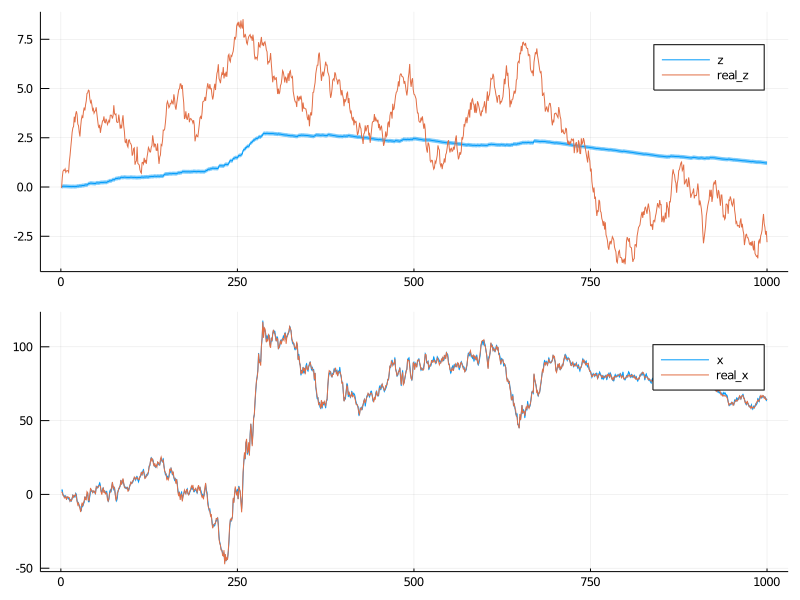

In [330]:
plot_dimension(mz, mx, 2)

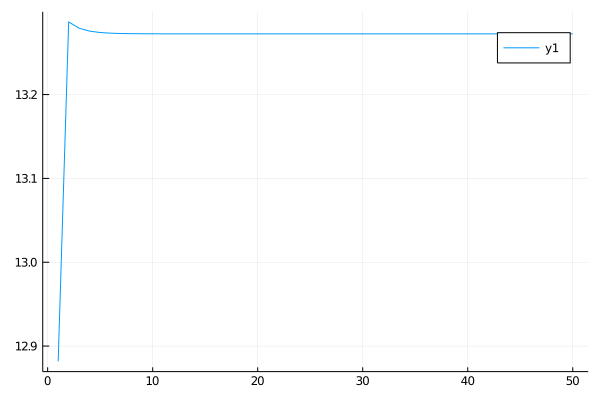

In [337]:
fevalues = reshape(fe, (iters, n))
p3 = plot(sum(fevalues[1:end, 1:end], dims = 2) / n)